# **SCDAA Coursework 2024-2025**
---

In [2]:
import utils.exercises1_1 as ex1_1
import utils.exercises1_2 as ex1_2
import utils.exercises2_1 as ex2_1
import utils.exercises3_1 as ex3_1
import matplotlib.pyplot as plt
import importlib
import torch
import numpy as np

## **Exercise 1.1 (Solving LQR using from Ricattic ODE)**

Write a class which:
1. Can be initialised with the matrices specifying the LQR problem and $T > 0$ and a time grid (numpy array or torch tensor). 
2. Has a method which will solve (approximate) the associated Ricatti ODE on this time grid. 
3. Has a method that, given one torch 1d-tensor (for time) and another torch 2d-tensor (for space), will return a 1d-torch tensor the control problem value $v(t, x)$ for the given $t, x$. If t is not on the time grid use $t_n$ which belongs to the grid and is the the nearest to $t$ (or the biggest $t_n$ smaller than $t$). 
4. Has a method that, given one torch 1d-tensor (for time) and another torch 2d-tensor (for space), will return a 2d-torch tensor with entries being the optimal Markov control function for the given $t, x$ i.e..

In [3]:
importlib.reload(ex1_1)

# (1)Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5
N = 100

# (2)Initialize LQR function (include solving the associated Ricatti ODE)
lqr = ex1_1.LQR(H, M, C, D, R, sigma, T, N)

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

# (3)Solve the value function v(t, x)
v = lqr.value_function(t0, x0)
print("Value function v(t, x):", v.item())

# (4)Solve the optimal control a(t, x)
a = lqr.optimal_control(t0, x0)
print("Optimal control a(t, x):", a.tolist())

Value function v(t, x): 0.7838265895843506
Optimal control a(t, x): [-1.2770085334777832, -5.199576377868652]


/Users/zzzz/github/SCADD_Group8/utils/exercises1_1.py:55: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  value = x.T @ S_t @ x
/Users/zzzz/github/SCADD_Group8/utils/exercises1_1.py:62: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
 

## **Exercise 1.2 (LQR MC checks)**

Run a Monte Carlo simulation of the system with the optimal solution you have obtained and ensure that you’re converging to the optimal value function you obtained in Exercise 1.1. You should check at least the case $t = 0$ and $x = (1, 1)$ and say $x = (2, 2)$ but of course few more would do no harm. In principle the value function is defined on the whole of $[0, T] \times R^2$ so we should check many more points against e.g. supremum norm but running the tests on some grid in this will get very computationally heavy very fast. 

Fix $T = 1/2$. In particular what we want to see:
1. With number of Conte Carlo samples large (e.g. 10000) vary the number of time steps in your simulation, take $2^1$, $2^2$, . . . , $2^{11}$ and plot the error as a log-log plot. What is the expected convergence rate and what do you observe? 
2. With a number of time steps large e.g. 10000 vary the number of Monte-Carlo samples, take $2 \cdot 4^0$, $2 \cdot 4^1$, . . . , $2 \cdot 4^5$ and plot the error as a log-log plot. What is the expected convergence rate and what do you observe?

*Hint:* Let $a = a(t, x)$ denote the optimal control from Exercise 1.1. Once you’ve plugged this in (1) you get 
```math
dX_s = [HX_s + Ma(s, X_s)] ds + \sigma dW_s , \quad s \in [t, T] ,\quad X_t = x
```
To do a time discretisation fix $N \in \mathbb{N}$ (number of time steps); let $\tau := T/N$ be the time step. Assume from now that you’d only possible want to start the SDE at times $t_k = k\tau$ for some $k = 0, 1, . . . , N$. You have a choice of (at least) two schemes since you know $a(t, x) = −D^{−1}M_TS(t)x$.

Explicit: 
```math
X_{t_{n+1}}^{N} = X_{t_n}^{N} + \tau [HX_{t_n}^N − MD^{−1}M_TS(t_n)X_{t_n}^N )] + \sigma (W_{t_{n+1}}−W_{t_n} ), \quad n = k, . . . , N , \quad X_{t_k}^N = x . 
```
Implicit: 
```math
X_{t_{n+1}}^{N} = X_{t_{n+1}}^{N} + \tau [HX_{t_{n+1}}^N − MD^{−1}M_TS(t_{n+1})X_{t_{n+1}}^N )] + \sigma (W_{t_{n+1}}−W_{t_n} ), \quad n = k, . . . , N , \quad X_{t_k}^N = x . 
```

In [4]:
importlib.reload(ex1_2)

# Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5
N = 10000

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

# 
lqr = ex1_1.LQR(H, M, C, D, R, sigma, T, N)
v = lqr.value_function(t0, x0)

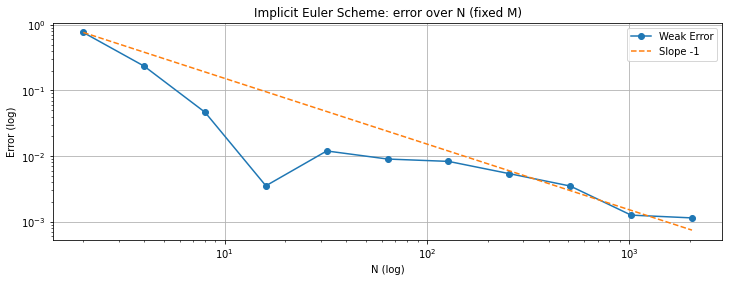


===== Convergence Rate Analysis =====
The slope of Error over N  = -0.80


In [5]:
importlib.reload(ex1_2)

# (1) Fixed M, change N, observe the error
M_samples_fixed = 10000
N_step_list = [2 ** k for k in range(1, 12)]  # 2^1 到 2^11

# Calculate the error over N
err_N = ex1_2.error_on_N(H, M, C, D, R, sigma, T, M_samples_fixed, N_step_list, v, t0, x0)

# Plot the log-log Plot
ex1_2.loglog_plot(N_step_list, err_N, 'M', 'N')

# Calculate the convergence rate
slope_N = ex1_2.compute_error_slope(np.array(N_step_list), np.array(err_N))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over N  = {slope_N:.2f}")

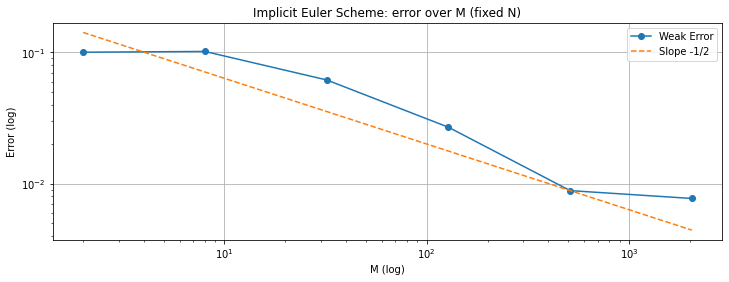


===== Convergence Rate Analysis =====
The slope of Error over M  = -0.43


In [6]:
importlib.reload(ex1_2)

# (2) Fixed N, change M, observe the error
N_fixed = 10000
M_samples_list = [2 * 4 ** k for k in range(6)]

# Calculate the error over M
err_M = ex1_2.error_on_M(H, M, C, D, R, sigma, T, N_fixed, M_samples_list, v, t0, x0)

# Plot the log-log Plot
ex1_2.loglog_plot(M_samples_list, err_M, 'N', 'M')

# Calculate the convergence rate
slope_M = ex1_2.compute_error_slope(np.array(M_samples_list), np.array(err_M))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over M  = {slope_M:.2f}")

/Users/zzzz/github/SCADD_Group8/utils/exercises1_1.py:62: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, t, self.T)  # 使用数值积分计算积分项


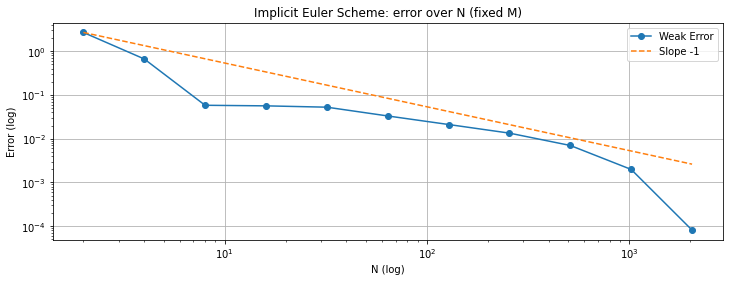


===== Convergence Rate Analysis =====
The slope of Error over N  = -1.12


In [7]:
importlib.reload(ex1_2)
# Change the initial value of x
x1 = torch.tensor([2.0, 2.0])

# Solve the value function on x1
v1 = lqr.value_function(t0, x1)

# (1) Fixed M, change N, observe the error
M_samples_fixed = 10000
N_step_list = [2 ** k for k in range(1, 12)]  # 2^1 到 2^11

# Calculate the error over N
err_N = ex1_2.error_on_N(H, M, C, D, R, sigma, T, M_samples_fixed, N_step_list, v1, t0, x1)

# Plot the log-log Plot
ex1_2.loglog_plot(N_step_list, err_N, 'M', 'N')

# Calculate the convergence rate
slope_N = ex1_2.compute_error_slope(np.array(N_step_list), np.array(err_N))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over N  = {slope_N:.2f}")

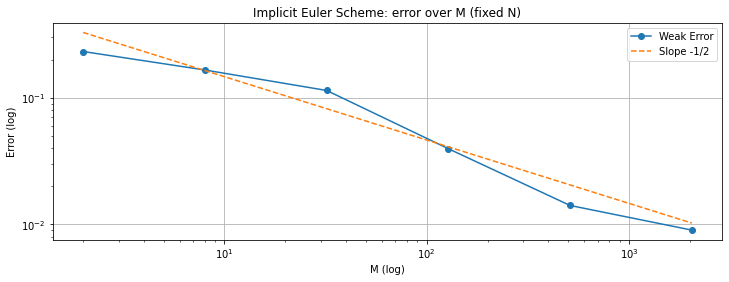


===== Convergence Rate Analysis =====
The slope of Error over M  = -0.51


In [8]:
importlib.reload(ex1_2)

# (2) Fixed N, change M, observe the error
N_fixed = 10000
M_samples_list = [2 * 4 ** k for k in range(6)]

# Calculate the error over M
err_M = ex1_2.error_on_M(H, M, C, D, R, sigma, T, N_fixed, M_samples_list, v1, t0, x1)

# Plot the log-log Plot
ex1_2.loglog_plot(M_samples_list, err_M, 'N', 'M')

# Calculate the convergence rate
slope_M = ex1_2.compute_error_slope(np.array(M_samples_list), np.array(err_M))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over M  = {slope_M:.2f}")

# **Exercises 2.1 (Solving soft LQR)**

For the soft LQR problem introduced in [1] do the following. 

1. As Exercise 1.1 parts 1. and 2. with additional input $\tau$ and $\gamma$ (strength of entropic regularization and variance of prior normal density respectively). 
2. As Exercise 1.1 part 3. 
3. As Exercise 1.1 part 4. Note that the exact solution only gives you a distribution that you have to sample the actual action from. 
4. For the problem given in Figure 1 and taking $\tau$ = 0.1 and $\gamma$ = 10 run and plot the resulting four controlled trajectories for the strict LQR and relaxed LQR from four different starting points: [2, 2], [2, −2], [−2, −2], [−2, 2]. Note that you need to use the same samples to create the Brownian motion for both the strict and the relaxed problem to see something that’s comparable.

In [9]:
importlib.reload(ex2_1)

# (1)Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5 # 可以试0.0
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 1
N = 1000    # dt = T/N = 0.001

# Initialize additional input
tau = 10
gamma = 10

# Initialize soft LQR function (include solving the associated Ricatti ODE)
soft_lqr = ex2_1.Soft_LQR(H, M, C, D, R, sigma, T, N, tau, gamma)

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

# (2)Solve the value function v(t, x)
v = soft_lqr.value_function(t0, x0)
print("Value function v(t, x):", v.item())

# (3)Solve the optimal control distribution pi(t, x)
control_dist = soft_lqr.optimal_control(t0, x0)

# Obtain the mean and convariance of the distribution
print("Optimal control mean μ(t, x):", control_dist.mean.tolist())
print("Optimal control covariance Σ_a:", control_dist.covariance_matrix.tolist())

# Sample a optimal control
sampled_control = control_dist.sample()
print("Sampled control a*(t, x):", sampled_control.tolist())

Value function v(t, x): 5.15438175201416


/Users/zzzz/github/SCADD_Group8/utils/exercises2_1.py:69: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, t, self.T)  # 使用数值积分计算积分项


Optimal control mean μ(t, x): [-1.2593152523040771, -4.282013416290283]
Optimal control covariance Σ_a: [[1.5, 0.10000000894069672], [0.10000000894069672, 1.5]]
Sampled control a*(t, x): [-2.1460790634155273, -5.21428918838501]


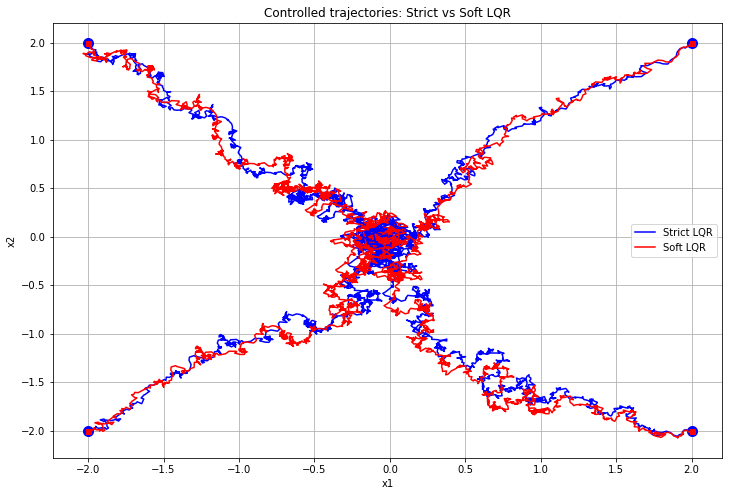

In [10]:
importlib.reload(ex1_1)
importlib.reload(ex2_1)

# (4)Initialize dW for strict lqr and soft lqr
dt = T/N
torch.manual_seed(1234)
dW = torch.randn(N, 2) * np.sqrt(dt)

# four initial states
initial_states = torch.tensor([[2.0, 2.0], [2.0, -2.0], [-2.0, -2.0], [-2.0, 2.0]])

# Initialize LQR function
lqr = ex1_1.LQR(H, M, C, D, R, sigma, T, N)

ex2_1.plot_x_trajectory(initial_states, lqr, soft_lqr, dW)

## **Exercise 3.1 (Critic algorithm)**
Implement the critic algorithm from [1] (use the optimal policy from Exercise 2) and verify that it’s correctly learning the value function of the optimal policy.
Hints: 

1. You can use the problem setup from Figure 1 but D just identity, with $T = 1/2, \tau = 1/2, \gamma = 1, N = 100$.
2. You can use the parametrization in Section B but you still need another method to turn the parameters (the matrix and the offset) into the value function parametrization. 
3. If you use the Adam optimizer with learning rate of $10^{−3}$ and 512 for the width of the hidden layer, $\tau = 0.5$, you would expect to see the critic loss to go from  $\sim 10^8$ to $\sim 10^6$. The maximum error against the exact optimal value function on $\{0, 1/6, 2/6, 1/2\} \times [−3, 3] \times [−3, 3]$ from Exercise 2.1 will be about $10^2$. This may seem not good enough but it will suffice for the actor-critic algorithm (Exercise 5.1) to learn.

Do not expect the same accuracy as for the Monte-Carlo approach - there is no convergence result for the the critic algorithm.

In [11]:
importlib.reload(ex3_1)

# (1)Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.eye(2)
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5
N = 100

# Initialize additional input
tau = 0.5
gamma = 1
n_episodes = 500
lr = 1e-3

# Initialize SoftLQR environment
env = ex3_1.SoftLQREnvironment(H, M, C, D, R, sigma, T, N, tau, gamma)

# (2)Value function parametrization
# policy = ex3_1.CriticPolicy(hidden_dim = 512)
valuenn = ex3_1.ValueNN(hidden_dim = 512)

# (3)Use offline critic algorithm to compute critic_loss
# critic_loss = ex3_1.OfflineCriticAlgorithm_1(env, policy, n_episodes, lr)
critic_loss = ex3_1.OfflineCriticAlgorithm(env, valuenn, n_episodes, lr)

Epoch 0: Loss = 116.984985
Epoch 100: Loss = 0.115347
Epoch 200: Loss = 0.073663
Epoch 300: Loss = 0.057330
Epoch 400: Loss = 0.046232


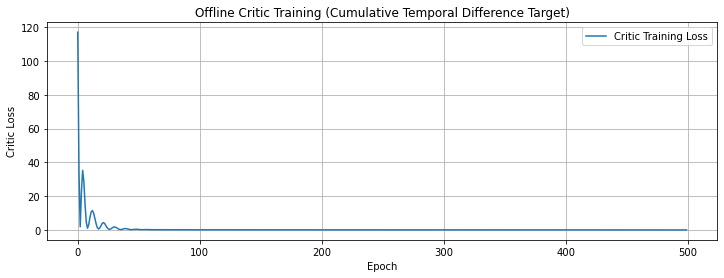

In [12]:
importlib.reload(ex3_1)

ex3_1.plot_critic_loss(critic_loss)

In [13]:
importlib.reload(ex3_1)
valuenn = ex3_1.ValueNN(hidden_dim = 512)

# Find the maximun error against the exact optimal value function
t_test = [0.0, 1/6, 2/6, 0.5]
x_range = np.linspace(-3, 3, 13)
ex3_1.find_maximum_error(env, valuenn, t_test, x_range)


/Users/zzzz/github/SCADD_Group8/utils/exercises3_1.py:69: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, t, self.T)  # 使用数值积分计算积分项


Max error on specified grid: 230.95


## **Exercise 4.1(Actor algorithm)**
Implement the actor algorithm from [1] (use the optimal value function from Exercise 2) and verify that it’s correctly learning the optimal policy.

## **Exercise 5.1 (Actor-critic algorithm)**
Implement the actor critic algorithm from [1] and verify its correctness.